In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [15]:
# Carregar os dados

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Carregar os dados
gluon_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/g_jets.csv', header=None, delimiter='\s+')
quark_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/q_jets.csv', header=None, delimiter='\s+')
top_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/t_jets.csv', header=None, delimiter='\s+')


In [17]:
# Reshape para obter a forma [N, 30, 4]
def reshape_data(df):
    return df.values.reshape(-1, 30, 4)

data_g = reshape_data(gluon_df)
data_q = reshape_data(quark_df)
data_t = reshape_data(top_df)

# Combine todos os dados e crie rótulos
data = np.concatenate((data_g, data_t, data_q), axis=0)
labels = np.concatenate((
    np.zeros(len(data_g)),  # 0 para gluons
    np.ones(len(data_t)),   # 1 para tops
    np.full(len(data_q), 2) # 2 para quarks
))

# Extrair as coordenadas eta, phi e pt_rel
eta = data[:, :, 0]
phi = data[:, :, 1]
pt_rel = data[:, :, 2]

# Função para calcular a diferença mínima de ângulo considerando a periodicidade de phi
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    dphi = np.mod(dphi + np.pi, 2 * np.pi) - np.pi
    return dphi

# Calcular R_ij
def calculate_Rij(eta, phi):
    num_particles = eta.shape[1]
    R_ij = np.zeros((eta.shape[0], num_particles, num_particles))

    for i in range(num_particles):
        for j in range(num_particles):
            delta_eta = eta[:, i] - eta[:, j]
            delta_phi_ij = delta_phi(phi[:, i], phi[:, j])
            R_ij[:, i, j] = np.sqrt(delta_eta**2 + delta_phi_ij**2)

    return R_ij

R_ij = calculate_Rij(eta, phi)

# Extrair características de R_ij (exemplo: média e desvio padrão)
features_Rij = np.zeros((R_ij.shape[0], 2))
features_Rij[:, 0] = R_ij.mean(axis=(1, 2))
features_Rij[:, 1] = R_ij.std(axis=(1, 2))

# Extrair características de pt_rel (exemplo: média, desvio padrão, valor máximo)
features_pt_rel = np.zeros((pt_rel.shape[0], 3))
features_pt_rel[:, 0] = pt_rel.mean(axis=1)
features_pt_rel[:, 1] = pt_rel.std(axis=1)
features_pt_rel[:, 2] = pt_rel.max(axis=1)

# Concatenar todas as características
features = np.concatenate((features_Rij, features_pt_rel), axis=1)


In [18]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [19]:
# Treinar um classificador
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Avaliar o classificador
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Gluon", "Top", "Quark"]))

              precision    recall  f1-score   support

       Gluon       0.69      0.69      0.69     35483
         Top       0.75      0.81      0.78     35632
       Quark       0.75      0.69      0.72     34061

    accuracy                           0.73    105176
   macro avg       0.73      0.73      0.73    105176
weighted avg       0.73      0.73      0.73    105176



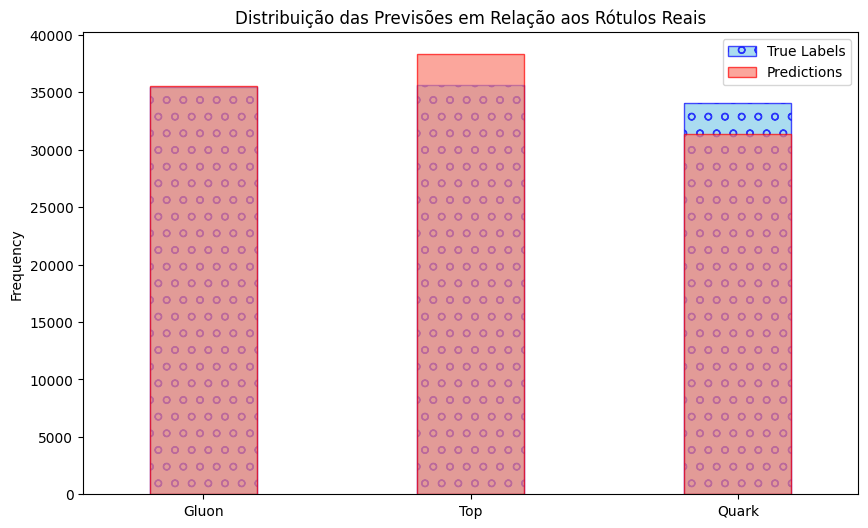

In [20]:
# Supondo que y_test e y_pred estejam disponíveis como arrays
# Se necessário, converter y_test para uma Série do pandas para contar as ocorrências
true_counts = pd.Series(y_test).value_counts()
pred_counts = pd.Series(y_pred).value_counts()

# Ordenar as séries por índice (classes)
true_counts = true_counts.sort_index()
pred_counts = pred_counts.sort_index()

# Plot da distribuição das previsões em relação aos rótulos reais
plt.figure(figsize=(10, 6))
true_counts.plot(kind='bar', color='skyblue', alpha=0.7, label='True Labels', hatch='o', edgecolor='blue', width=0.4)
pred_counts.plot(kind='bar', color='salmon', alpha=0.7, label='Predictions', edgecolor='red', width=0.4)

plt.title('Distribuição das Previsões em Relação aos Rótulos Reais')
#plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Gluon', 'Top', 'Quark'], rotation=0)
plt.legend()
plt.show()

